# MicroGrad

A tiny Autograd engine

![awww](puppy.jpg)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# The tiniest Autograd engine. It's so cute!

class Value:
    """ stores a single scalar value and its gradient """
    
    def __init__(self, data):
        self.data = data
        self.grad = 0
        self.backward = lambda: None
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # attempt to wrap if given an int/float/etc
        out = Value(self.data + other.data)
        
        def backward():
            self.grad += out.grad
            other.grad += out.grad
            self.backward()
            other.backward()
        out.backward = backward
        
        return out
    
    def __radd__(self, other):
        return self.__add__(other)
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # attempt to wrap if given an int/float/etc
        out = Value(self.data * other.data)
        
        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            self.backward()
            other.backward()
        out.backward = backward
        
        return out
    
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data)
        def backward():
            self.grad += (out.data > 0) * out.grad
            self.backward()
        out.backward = backward
        return out
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"


In [3]:
# A neural networks "library" :D on top of it! I'm dying

class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

class Neuron(Module):
    
    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin
    
    def __call__(self, x):
        act = sum([wi*xi for wi,xi in zip(self.w, x)], self.b)
        return act.relu() if self.nonlin else act 
    
    def parameters(self):
        return self.w + [self.b]
    
    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):
    
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]
    
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"


In [4]:
np.random.seed(1337)
random.seed(1337)

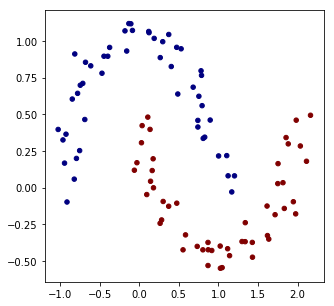

In [5]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [6]:
# initialize a model 
#model = MLP(2, [12, 10, 1]) # 2-layer neural network
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [7]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(Value(yi) * scorei + 1).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [yi == (int(scorei.data < 0)*2-1) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.1560272899423576, grad=0) 0.5


In [8]:
# optimization
learning_rate = 0.001

for k in range(200):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.grad = 1
    total_loss.backward()
    
    # update (sgd)
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 1.1560272899423576, accuracy 50.0%
step 1 loss 1.5468491167071179, accuracy 50.0%
step 2 loss 1.2021105302261552, accuracy 50.0%
step 3 loss 0.966935857742637, accuracy 59.0%
step 4 loss 0.8232331805728894, accuracy 68.0%
step 5 loss 0.7356809163892809, accuracy 70.0%
step 6 loss 0.6860408935788103, accuracy 74.0%
step 7 loss 0.6658413011177632, accuracy 71.0%
step 8 loss 0.638051851012845, accuracy 74.0%
step 9 loss 0.6089352022220705, accuracy 75.0%
step 10 loss 0.5834899120867706, accuracy 77.0%
step 11 loss 0.5624132478316041, accuracy 76.0%
step 12 loss 0.546382386918789, accuracy 77.0%
step 13 loss 0.5251134632393725, accuracy 78.0%
step 14 loss 0.5096683473198049, accuracy 79.0%
step 15 loss 0.49403581008508085, accuracy 78.0%
step 16 loss 0.4809749834485958, accuracy 78.0%
step 17 loss 0.45498541176808344, accuracy 79.0%
step 18 loss 0.43383641366567494, accuracy 80.0%
step 19 loss 0.4133872374672309, accuracy 83.0%
step 20 loss 0.3949011845842829, accuracy 83.0%
st

step 168 loss 0.06889133150887823, accuracy 100.0%
step 169 loss 0.06585882693226622, accuracy 100.0%
step 170 loss 0.065534224126955, accuracy 100.0%
step 171 loss 0.06642120780859764, accuracy 99.0%
step 172 loss 0.07036344441064256, accuracy 100.0%
step 173 loss 0.06434457178446804, accuracy 100.0%
step 174 loss 0.07057410384496458, accuracy 100.0%
step 175 loss 0.06360567978062148, accuracy 100.0%
step 176 loss 0.0683835917621888, accuracy 100.0%
step 177 loss 0.06095292627441029, accuracy 100.0%
step 178 loss 0.06251457342696964, accuracy 100.0%
step 179 loss 0.06011189328891595, accuracy 100.0%
step 180 loss 0.06270048859585112, accuracy 100.0%
step 181 loss 0.05766597058490163, accuracy 100.0%
step 182 loss 0.06672680890554591, accuracy 100.0%
step 183 loss 0.06178847289409725, accuracy 100.0%
step 184 loss 0.05778653286930187, accuracy 100.0%
step 185 loss 0.05451700258994074, accuracy 100.0%
step 186 loss 0.05435893176864256, accuracy 100.0%
step 187 loss 0.053020730846958734,

(-1.548639298268643, 1.951360701731357)

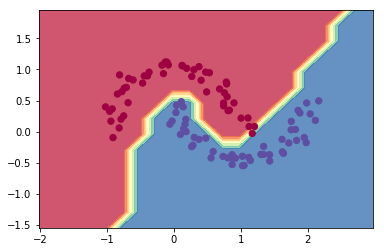

In [9]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data < 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
